<a href="https://colab.research.google.com/github/alina-bogdanovskaya/PyTorch_Jan2023/blob/lesson6/HW06.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install stop_words

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install pymorphy2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!pip install nlpaug

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
import nltk
from string import punctuation
from nltk.corpus import stopwords
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
from nltk.stem import WordNetLemmatizer
import re
from sklearn.model_selection import train_test_split

In [6]:
sw_sw = set(get_stop_words('en'))

In [7]:
nltk.download('stopwords')
sw_nltk = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
len(sw_sw), len(sw_nltk)

(174, 179)

In [9]:
DATA_PATH = '/content/drive/MyDrive/GB/PyTorch/twitter_sentiment'
train_df = pd.read_csv(DATA_PATH + '/train.csv')
test_df = pd.read_csv(DATA_PATH + '/test.csv')

In [10]:
def num_of_words(df):
    df['word_count'] = df['tweet'].apply(lambda x : len(str(x).split(" ")))
    print(df[['tweet','word_count']].head())

def num_of_chars(df):
    df['char_count'] = df['tweet'].str.len() ## this also includes spaces
    print(df[['tweet','char_count']].head())

In [11]:
train_df

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
...,...,...,...
31957,31958,0,ate @user isz that youuu?ðððððð...
31958,31959,0,to see nina turner on the airwaves trying to...
31959,31960,0,listening to sad songs on a monday morning otw...
31960,31961,1,"@user #sikh #temple vandalised in in #calgary,..."


In [12]:
train_df.label.value_counts()


0    29720
1     2242
Name: label, dtype: int64

In [13]:
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download("punkt")


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [14]:
lemmatizer = WordNetLemmatizer()
lemmatizer.lemmatize('conversations')

'conversation'

In [15]:
def preprocess_text(txt):
    txt = txt.replace('@user ', '')
    for symbol in punctuation:
        txt = txt.replace(symbol, ' ')
    txt = txt.lower()
    # print(txt)
    txt = [word for word in txt if (word.isalnum() or word.isspace()) and not word.isdigit()]
    # print(txt)
    txt = "".join(txt)
    # print(txt)
    txt = [word for word in txt.split() if word not in sw_nltk]
    # print(txt)
    txt = [*map(lemmatizer.lemmatize, txt)]
    # print(txt)
    txt = [word for word in txt if len(word) > 2]
    # print(txt)
    txt = " ".join(txt)
    
    return txt


In [16]:
train_df['tweet'].iloc[:1].values

array([' @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run'],
      dtype=object)

In [17]:
train_df['tweet'].iloc[:1].apply(preprocess_text).values

array(['father dysfunctional selfish drag kid dysfunction run'],
      dtype=object)

In [18]:
from tqdm import tqdm
tqdm.pandas()

train_df.tweet = train_df.tweet.progress_apply(preprocess_text)

100%|██████████| 31962/31962 [00:03<00:00, 8163.04it/s]


In [19]:
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=897)

In [20]:
train_corpus = ' '.join(train_df.tweet)
train_corpus = train_corpus.lower()

In [21]:
from nltk.tokenize import word_tokenize

tokens = word_tokenize(train_corpus)
tokens[:9]

['interstellar',
 'really',
 'hit',
 'feel',
 'lois',
 'duncan',
 'died',
 'met',
 'time']

In [22]:
num_of_words(train_df)

                                                   tweet  word_count
11307                       interstellar really hit feel           4
6891   lois duncan died met time fascinating nice lov...           9
30277                                  today special day           3
16250                                                              1
15161             gold errythang gold baltimore maryland           5


In [23]:
num_of_chars(train_df)

                                                   tweet  char_count
11307                       interstellar really hit feel          28
6891   lois duncan died met time fascinating nice lov...          53
30277                                  today special day          17
16250                                                              0
15161             gold errythang gold baltimore maryland          38


In [24]:
train_df.char_count.median()

54.0

In [25]:
max_words = 3500
max_len = 55
num_classes = 1

batch_size = 256
print_batch_n = 100

In [26]:
from nltk.probability import FreqDist

dist = FreqDist([word for word in tokens if word.isalnum()])
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]  # вычитание 1 для padding
len(tokens_filtered_top)

3499

In [27]:
vocab = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}

In [28]:
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocab:
            result.append(vocab[word])

    padding = [0] * (maxlen-len(result))
    return result[-maxlen:] + padding

In [29]:
x_train = np.asarray([text_to_sequence(text, max_len) for text in train_df.tweet])
x_val = np.asarray([text_to_sequence(text, max_len) for text in val_df.tweet])

In [30]:
len(x_train)

25569

In [31]:
# from imblearn.over_sampling import SMOTE

# smt = SMOTE(random_state=42, k_neighbors=1)
# x_train, y_train = smt.fit_resample(x_train, train_df.label)
# y_train = np.asarray(y_train)
y_train = np.asarray(train_df.label)

In [32]:
class Net(nn.Module):
    def __init__(self, vocab_size=2000, embedding_dim=128, out_channel=128, num_classes=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.dp_1 = nn.Dropout(0.3)
        self.conv_1 = nn.Conv1d(embedding_dim, out_channel, kernel_size=2)
        self.conv_2 = nn.Conv1d(embedding_dim, out_channel, kernel_size=3)
        self.pool = nn.MaxPool1d(2)
        self.relu = nn.LeakyReLU(0.1)
        self.linear_1 = nn.Linear(out_channel, out_channel // 2)
        self.dp_2 = nn.Dropout(0.3)
        self.linear_2 = nn.Linear(out_channel // 2, num_classes)
        
    def forward(self, x):        
        output = self.embedding(x) # B, L, E
        #                       B  E  L         
        output = self.dp_1(output)
        output = output.permute(0, 2, 1)
        output = self.conv_1(output)
        output = self.relu(output)
        output = self.pool(output)

        output = self.conv_2(output)
        output = self.relu(output)
        output = self.pool(output)
        output = torch.max(output, axis=2).values
        output = self.linear_1(output)
        output = self.relu(output)
        output = self.dp_2(output)
        output = self.linear_2(output)
        output = torch.sigmoid(output)
        return output

In [33]:
class DataWrapper(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).long()
        self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [34]:
train_ds = DataWrapper(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

val_ds = DataWrapper(x_val, val_df.label.values)
val_dl = DataLoader(val_ds, batch_size=8, shuffle=True)

In [35]:
model = Net(vocab_size=max_words)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [36]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.BCELoss()

In [37]:
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, classification_report
import time

In [38]:
epochs = 10

model = model.to(device)
model.train()
th = 0.5

train_loss_history = []
test_loss_history = []


for epoch in range(epochs):  
    running_loss, running_items, running_right, batches, F1_train = 0.0, 0.0, 0.0, 0.0, 0.0
    for i, data in enumerate(train_dl, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # обнуляем градиент
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, labels.float().view(-1, 1))
        running_loss += loss.item()
        batches += 1
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        # F1_train += f1_score(labels.detach().numpy(), pred_labels.detach().numpy())
        running_right += (labels == pred_labels).sum()
        
    # выводим статистику о процессе обучения
    model.eval()
    
    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
            f'Step [{i + 1}/{len(train_dl)}]. ' \
            f'Loss: {running_loss / batches:.3f}. ' \
            f'Acc: {running_right / running_items:.3f}', end='. ')
    train_loss_history.append(running_loss / batches)

        # выводим статистику на тестовых данных
    test_running_right, test_running_total, test_running_loss, batches, F1_test = 0.0, 0.0, 0.0, 0.0, 0.0
    for j, data in enumerate(val_dl):
        test_labels = data[1].to(device)
        test_outputs = model(data[0].to(device))
        
        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        test_running_loss += test_loss.item()
        batches += 1
        # подсчет метрики на тесте
        test_running_total += len(data[1])
        pred_test_labels = torch.squeeze((test_outputs > th).int())
        # F1_test += f1_score(test_labels.detach().numpy(), pred_test_labels.detach().numpy())
        test_running_right += (test_labels == pred_test_labels).sum()
    
    test_loss_history.append(test_running_loss / batches)
    print(f'Test loss: {test_running_loss / batches:.3f}. Test acc: {test_running_right / test_running_total:.3f}')
    
    model.train()
        
print('Training is finished!')

Epoch [1/10]. Step [100/100]. Loss: 0.285. Acc: 0.920. Test loss: 0.274. Test acc: 0.928
Epoch [2/10]. Step [100/100]. Loss: 0.243. Acc: 0.930. Test loss: 0.230. Test acc: 0.928
Epoch [3/10]. Step [100/100]. Loss: 0.203. Acc: 0.931. Test loss: 0.181. Test acc: 0.936
Epoch [4/10]. Step [100/100]. Loss: 0.163. Acc: 0.944. Test loss: 0.166. Test acc: 0.946
Epoch [5/10]. Step [100/100]. Loss: 0.141. Acc: 0.951. Test loss: 0.152. Test acc: 0.950
Epoch [6/10]. Step [100/100]. Loss: 0.127. Acc: 0.955. Test loss: 0.147. Test acc: 0.950
Epoch [7/10]. Step [100/100]. Loss: 0.115. Acc: 0.960. Test loss: 0.145. Test acc: 0.952
Epoch [8/10]. Step [100/100]. Loss: 0.105. Acc: 0.963. Test loss: 0.147. Test acc: 0.954
Epoch [9/10]. Step [100/100]. Loss: 0.096. Acc: 0.966. Test loss: 0.146. Test acc: 0.954
Epoch [10/10]. Step [100/100]. Loss: 0.086. Acc: 0.970. Test loss: 0.151. Test acc: 0.954
Training is finished!


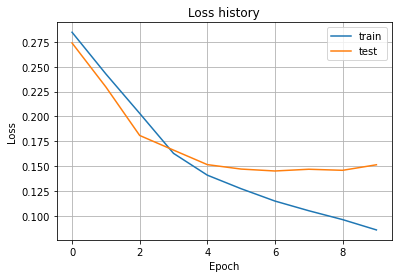

In [39]:
import matplotlib.pyplot as plt

plt.title('Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(train_loss_history, label='train')
plt.plot(test_loss_history, label='test')
plt.legend();

In [40]:
print(train_loss_history)

[0.28477640345692634, 0.24282465294003486, 0.20313662834465504, 0.16292124047875403, 0.1409730087220669, 0.12731270089745522, 0.1149085533618927, 0.10517682563513517, 0.09625970659777522, 0.08587188579142094]
